In [1]:
#Imports
import re
import unicodedata
import pandas as pd
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import acquire as a
import prepare as p
from env import get_connection

Spam Data

Load the spam data set.

In [2]:
#Get SQL database url
url = get_connection('spam_db')

In [3]:
#Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

In [4]:
#Read SQL
df = pd.read_sql(query, url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [5]:
def clean_text(text, extra_stopwords=['r', 'u', '2', 'ltgt']):
    
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s]', '', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
#Clean the text data by label
ham_words = clean_text(' '.join(df[df['label'] == 'ham']['text']))
spam_words = clean_text(' '.join(df[df['label'] == 'spam']['text']))
all_words = clean_text(' '.join(df['text']))

In [7]:
#Save the value counts of each series to a variable
ham_counts = pd.Series(ham_words).value_counts()
spam_counts = pd.Series(spam_words).value_counts()
all_counts = pd.Series(all_words).value_counts()

In [8]:
#Combine the value counts into one dataframe
word_freq = pd.concat([ham_counts, spam_counts, all_counts], axis=1)
word_freq.head()

,0,1,2
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279


In [9]:
#Check for nulls
word_freq.isna().sum()

0    1918
1    6086
2       0
dtype: int64

In [10]:
#Rename columns and fill null values
word_freq.columns = ['ham', 'spam', 'all']
word_freq.fillna(0, inplace=True)
word_freq.head()

,ham,spam,all
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279


In [11]:
#Check datatypes of columns
word_freq.dtypes

ham     float64
spam    float64
all       int64
dtype: object

In [12]:
#Recast all columns as integers
word_freq = word_freq.astype('int')
word_freq.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [13]:
#Calculate percentage of all words by label
word_freq['pct_ham'] = word_freq['ham'] / word_freq['all'] * 100
word_freq['pct_spam'] = word_freq['spam'] / word_freq['all'] * 100
word_freq.head()

,ham,spam,all,pct_ham,pct_spam
im,449,13,462,97.186147,2.813853
get,314,83,397,79.093199,20.906801
go,273,31,304,89.802632,10.197368
ok,272,5,277,98.194946,1.805054
dont,257,22,279,92.114695,7.885305


In [14]:
#Highest percent spam words
word_freq[word_freq['spam'] > 100].sort_values('pct_spam', ascending=False)

,ham,spam,all,pct_ham,pct_spam
claim,0,115,115,0.000000,100.000000
txt,13,150,163,7.975460,92.024540
mobile,15,135,150,10.000000,90.000000
free,59,216,275,21.454545,78.545455
stop,40,113,153,26.143791,73.856209
reply,43,102,145,29.655172,70.344828
text,77,137,214,35.981308,64.018692
call,241,359,600,40.166667,59.833333
4,168,119,287,58.536585,41.463415
ur,240,144,384,62.500000,37.500000


In [15]:
ham_bigrams = pd.Series(nltk.ngrams(ham_words, 2))
ham_bigrams.head(10)

0          (go, jurong)
1       (jurong, point)
2        (point, crazy)
3    (crazy, available)
4    (available, bugis)
5            (bugis, n)
6            (n, great)
7        (great, world)
8           (world, la)
9               (la, e)
dtype: object

In [16]:
top_ham_bigrams = ham_bigrams.value_counts().head(10)
top_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
dtype: int64

In [17]:
spam_bigrams = pd.Series(nltk.ngrams(spam_words, 2))
spam_bigrams.head(10)

0    (free, entry)
1    (entry, wkly)
2     (wkly, comp)
3      (comp, win)
4        (win, fa)
5        (fa, cup)
6     (cup, final)
7    (final, tkts)
8     (tkts, 21st)
9      (21st, may)
dtype: object

In [18]:
top_spam_bigrams = spam_bigrams.value_counts().head(10)
top_spam_bigrams

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
(prize, guaranteed)    22
(send, stop)           19
(selected, receive)    19
(await, collection)    19
(every, week)          19
dtype: int64

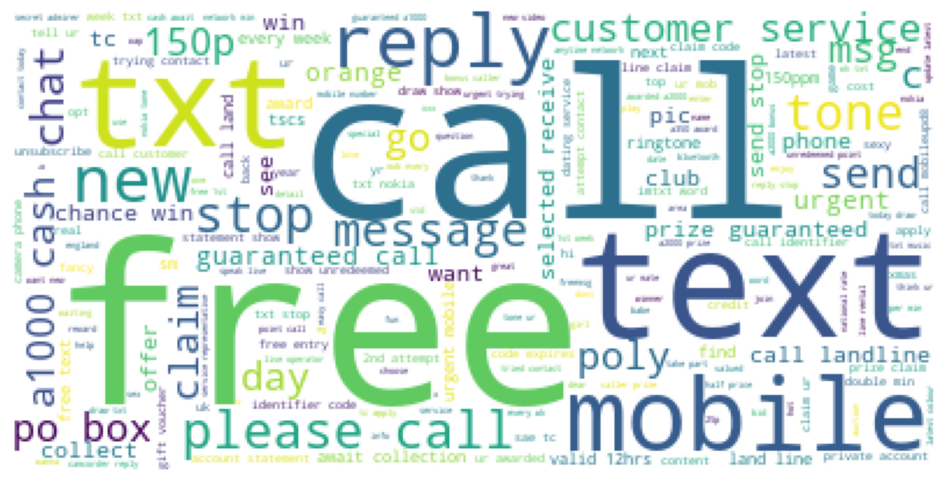

In [19]:
#Word cloud
all_cloud1 = WordCloud(background_color='white').generate(' '.join(spam_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud1)
plt.axis('off')
plt.show()

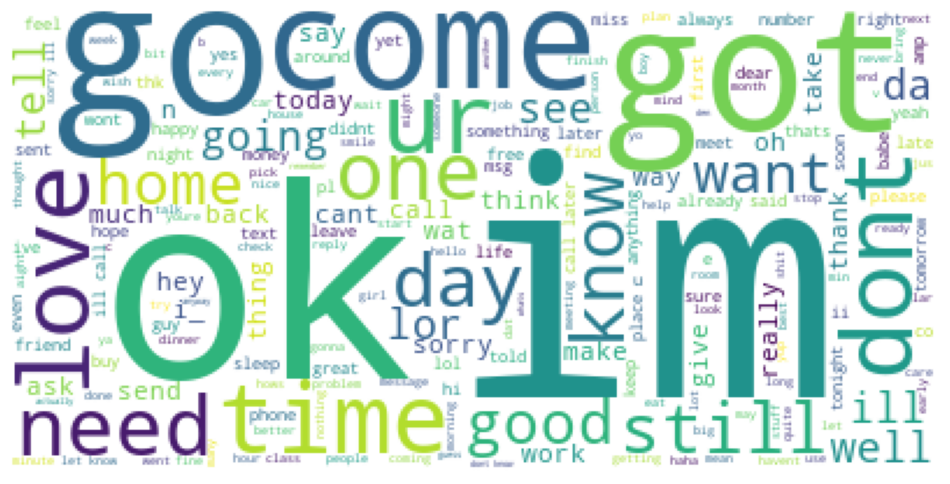

In [20]:
#Word cloud
all_cloud2 = WordCloud(background_color='white').generate(' '.join(ham_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud2)
plt.axis('off')
plt.show()

Is there any overlap in the bigrams for the spam data and the ham data?

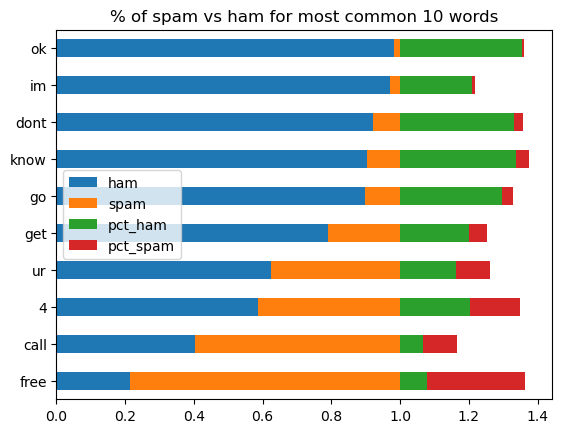

In [21]:
#visualize only ham and spam as percent of 'all'
(word_freq.sort_values(by='all', ascending=False)
 .head(10)
 .apply(lambda row: row/ row['all'],axis=1)
 .drop(columns='all')
 .sort_values(by='spam')
 .plot.barh(stacked=True)).invert_yaxis()
plt.title('% of spam vs ham for most common 10 words')
None

Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [22]:
ham_trigrams = pd.Series(nltk.ngrams(ham_words, 3))
ham_trigrams.head(10)

0          (go, jurong, point)
1       (jurong, point, crazy)
2    (point, crazy, available)
3    (crazy, available, bugis)
4        (available, bugis, n)
5            (bugis, n, great)
6            (n, great, world)
7           (great, world, la)
8               (world, la, e)
9              (la, e, buffet)
dtype: object

In [23]:
top_ham_trigrams = ham_trigrams.value_counts().head(10)
top_ham_trigrams

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
(right, pls, send)      12
(phone, right, pls)     12
(pick, phone, right)    12
(hi, hi, hi)            11
(x, x, x)                8
dtype: int64

In [24]:
spam_trigrams = pd.Series(nltk.ngrams(spam_words, 3))
spam_trigrams.head(10)

0    (free, entry, wkly)
1    (entry, wkly, comp)
2      (wkly, comp, win)
3        (comp, win, fa)
4         (win, fa, cup)
5       (fa, cup, final)
6     (cup, final, tkts)
7    (final, tkts, 21st)
8      (tkts, 21st, may)
9      (21st, may, 2005)
dtype: object

In [25]:
top_spam_trigrams = spam_trigrams.value_counts().head(10)
top_spam_trigrams

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
(2003, account, statement)    13
(camcorder, reply, call)      12
(guaranteed, a1000, cash)     12
(show, 800, unredeemed)       12
(urgent, trying, contact)     11
dtype: int64

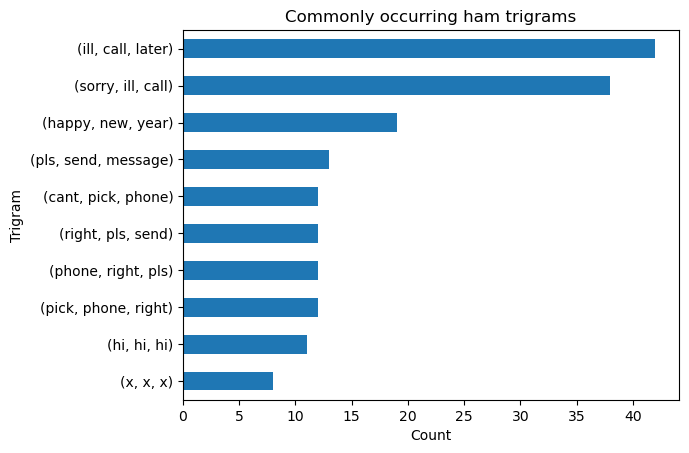

In [26]:
#Plot
top_ham_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.title('Commonly occurring ham trigrams')
plt.show()

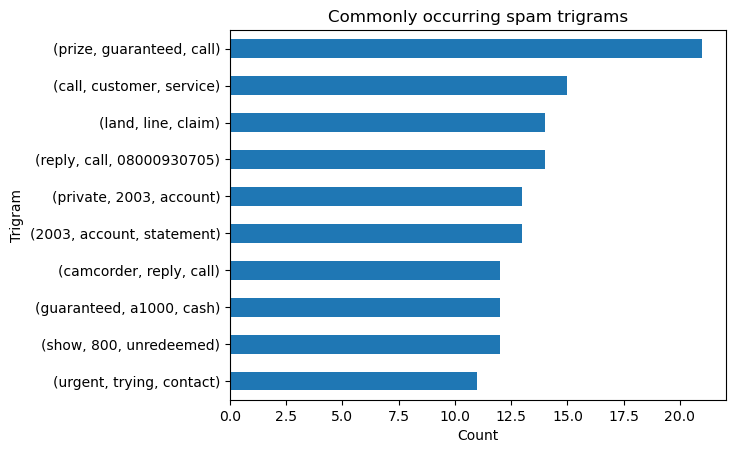

In [27]:
#Plot
top_spam_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.title('Commonly occurring spam trigrams')
plt.show()

Explore the blog articles using the techniques discussed in the exploration lesson.

In [32]:
#acquire codeup articles
codeup_df = pd.DataFrame(a.get_blog_articles('blog_posts.json'))

codeup_df.head()

,title,link,date_published,content
0,Black Excellence in Tech: Panelist Spotlight –...,https://inshorts.com/en/read/business/,"Feb 16, 2023",\nBlack excellence in tech: Panelist Spotlight...
1,Black excellence in tech: Panelist Spotlight –...,https://inshorts.com/en/read/business/,"Feb 13, 2023",\nBlack excellence in tech: Panelist Spotlight...
2,Black excellence in tech: Panelist Spotlight –...,https://inshorts.com/en/read/business/,"Feb 10, 2023",\nBlack excellence in tech: Panelist Spotlight...
3,Black excellence in tech: Panelist Spotlight –...,https://inshorts.com/en/read/business/,"Feb 6, 2023",\nBlack excellence in tech: Panelist Spotlight...
4,Coding Bootcamp or Self-Learning? Which is Bes...,https://inshorts.com/en/read/business/,"Jan 20, 2023",\nIf you’re interested in embarking on a caree...


In [37]:
def clean(text):
    '''
    This function is a simplified text cleaning function
    '''
    text = p.basic_clean(text)
    text = p.lemmatize(text)
    text = p.remove_stopwords(text)
    
    return list(text.split(' '))

In [38]:
#applying clean function to get all normalized text in content column
article = clean(' '.join(codeup_df.content))
article

['black',
 'excellence',
 'tech',
 'panelist',
 'spotlight',
 'wilmarie',
 'de',
 'la',
 'cruz',
 'mejia',
 'codeup',
 'hosting',
 'black',
 'excellence',
 'tech',
 'panel',
 'honor',
 'black',
 'history',
 'month',
 'february',
 '22',
 '2023',
 'celebrate',
 'wed',
 'like',
 'spotlight',
 'panelist',
 'leading',
 'discussion',
 'learn',
 'bit',
 'respective',
 'experience',
 'black',
 'leader',
 'tech',
 'industry',
 'meet',
 'wilmarie',
 'wilmarie',
 'de',
 'la',
 'cruz',
 'mejia',
 'current',
 'codeup',
 'student',
 'path',
 'becoming',
 'fullstack',
 'web',
 'developer',
 'dallas',
 'tx',
 'campus',
 'wilmarie',
 'veteran',
 'expanding',
 'knowledge',
 'programming',
 'language',
 'technology',
 'journey',
 'codeup',
 'asked',
 'wilmarie',
 'share',
 'experience',
 'codeup',
 'share',
 'wa',
 'able',
 'meet',
 'people',
 'passionate',
 'coding',
 'positive',
 'learning',
 'environment',
 'hope',
 'join',
 'u',
 'february',
 '22nd',
 'sit',
 'insightful',
 'conversation',
 'wilmarie

In [39]:
#turn all words into a series
#get value count of all words
pd.Series(all_words).value_counts()

#removing stopwords would change this count

call             600
im               462
get              397
ur               384
go               304
                ... 
cage               1
surrounded         1
cuck               1
weeddeficient      1
bitching           1
Length: 8900, dtype: int64

In [40]:
#assign to a variable
word_freq = pd.Series(article).value_counts()

In [41]:
#our top 5 words in the blogs are
word_freq.head()

codeup        27
tech          18
black         17
coding        14
experience    13
dtype: int64

Text(0, 0.5, 'Word')

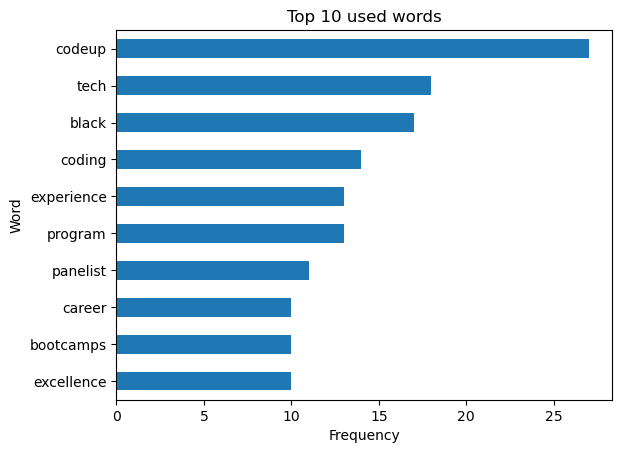

In [42]:
#visualize top 10
word_freq.head(10).plot.barh().invert_yaxis()

plt.title('Top 10 used words')
plt.xlabel('Frequency')
plt.ylabel('Word')

In [43]:
#put list of two word combos together
list(nltk.bigrams(article))

[('black', 'excellence'),
 ('excellence', 'tech'),
 ('tech', 'panelist'),
 ('panelist', 'spotlight'),
 ('spotlight', 'wilmarie'),
 ('wilmarie', 'de'),
 ('de', 'la'),
 ('la', 'cruz'),
 ('cruz', 'mejia'),
 ('mejia', 'codeup'),
 ('codeup', 'hosting'),
 ('hosting', 'black'),
 ('black', 'excellence'),
 ('excellence', 'tech'),
 ('tech', 'panel'),
 ('panel', 'honor'),
 ('honor', 'black'),
 ('black', 'history'),
 ('history', 'month'),
 ('month', 'february'),
 ('february', '22'),
 ('22', '2023'),
 ('2023', 'celebrate'),
 ('celebrate', 'wed'),
 ('wed', 'like'),
 ('like', 'spotlight'),
 ('spotlight', 'panelist'),
 ('panelist', 'leading'),
 ('leading', 'discussion'),
 ('discussion', 'learn'),
 ('learn', 'bit'),
 ('bit', 'respective'),
 ('respective', 'experience'),
 ('experience', 'black'),
 ('black', 'leader'),
 ('leader', 'tech'),
 ('tech', 'industry'),
 ('industry', 'meet'),
 ('meet', 'wilmarie'),
 ('wilmarie', 'wilmarie'),
 ('wilmarie', 'de'),
 ('de', 'la'),
 ('la', 'cruz'),
 ('cruz', 'mejia')

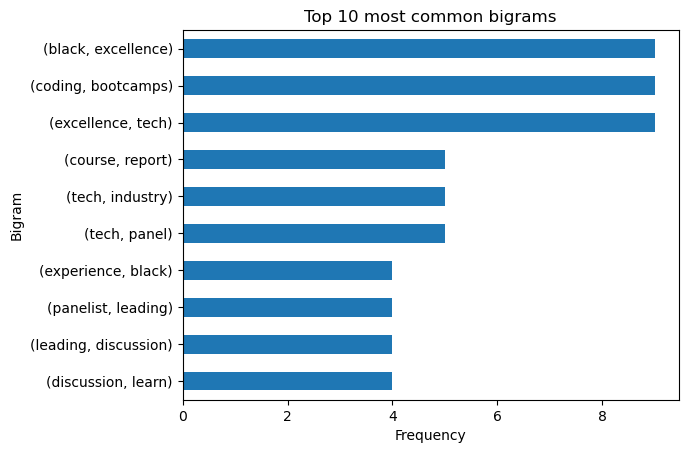

In [44]:
#visualize top ten
pd.Series(nltk.bigrams(article)).value_counts().head(10).plot.barh().invert_yaxis()
plt.title('Top 10 most common bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
None

Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [52]:
#Test my function!
topics = ['business', 'sports', 'technology', 'entertainment']

news_df = pd.DataFrame(a.get_news_articles(topics))
news_df.head()

,category,title,content
0,business,All Adani stocks end higher for the first time...,All 10 Adani Group stocks closed higher on Wed...
1,business,"Bill Gates meets Ratan Tata, N Chandrasekaran;...",Microsoft Co-founder Bill Gates met with Tata ...
2,business,SoftBank sells shares worth ₹954 crore in logi...,SoftBank sold shares worth ₹954 crore in logis...
3,business,Smriti Irani's 2011 tweet on LPG price hike re...,Hours after the central government raised the ...
4,business,"Indian-Americans Renjen, Subramaniam to be mem...",Indian-Americans Punit Renjen and Rajesh Subra...


In [54]:
#applying clean function to get all normalized text in content column
all_words = clean(' '.join(news_df.content))
all_words

['10',
 'adani',
 'group',
 'stock',
 'closed',
 'higher',
 'wednesday',
 'first',
 'occurrence',
 'since',
 'report',
 'u',
 'shortseller',
 'hindenburg',
 'research',
 'late',
 'january',
 'accused',
 'group',
 'fraud',
 'adani',
 'enterprise',
 'led',
 'rally',
 'advancing',
 'almost',
 '15',
 'group',
 'conducted',
 'investor',
 'meeting',
 'singapore',
 'hong',
 'kong',
 'adani',
 'transmission',
 'adani',
 'power',
 'rose',
 '5',
 'daily',
 'limit',
 'microsoft',
 'cofounder',
 'bill',
 'gate',
 'met',
 'tata',
 'son',
 'chairman',
 'emeritus',
 'ratan',
 'tata',
 'tata',
 'son',
 'chairman',
 'natarajan',
 'chandrasekaran',
 'bill',
 'enriching',
 'discussion',
 'ratan',
 'tata',
 'n',
 'chandrasekaran',
 'philanthropic',
 'initiative',
 'gate',
 'foundation',
 'india',
 'said',
 'tweet',
 'look',
 'forward',
 'strengthening',
 'work',
 'together',
 'partnering',
 'health',
 'diagnostics',
 'nutrition',
 'added',
 'softbank',
 'sold',
 'share',
 'worth',
 '954',
 'crore',
 'logi

In [55]:
#turn all words into a series
#get value count of all words
pd.Series(all_words).value_counts()

#removing stopwords would change this count

said       83
india      65
ha         49
added      39
wa         32
           ..
many        1
nap         1
footage     1
flight      1
2014        1
Length: 1795, dtype: int64

In [56]:
news_df = all_words
news_df

['10',
 'adani',
 'group',
 'stock',
 'closed',
 'higher',
 'wednesday',
 'first',
 'occurrence',
 'since',
 'report',
 'u',
 'shortseller',
 'hindenburg',
 'research',
 'late',
 'january',
 'accused',
 'group',
 'fraud',
 'adani',
 'enterprise',
 'led',
 'rally',
 'advancing',
 'almost',
 '15',
 'group',
 'conducted',
 'investor',
 'meeting',
 'singapore',
 'hong',
 'kong',
 'adani',
 'transmission',
 'adani',
 'power',
 'rose',
 '5',
 'daily',
 'limit',
 'microsoft',
 'cofounder',
 'bill',
 'gate',
 'met',
 'tata',
 'son',
 'chairman',
 'emeritus',
 'ratan',
 'tata',
 'tata',
 'son',
 'chairman',
 'natarajan',
 'chandrasekaran',
 'bill',
 'enriching',
 'discussion',
 'ratan',
 'tata',
 'n',
 'chandrasekaran',
 'philanthropic',
 'initiative',
 'gate',
 'foundation',
 'india',
 'said',
 'tweet',
 'look',
 'forward',
 'strengthening',
 'work',
 'together',
 'partnering',
 'health',
 'diagnostics',
 'nutrition',
 'added',
 'softbank',
 'sold',
 'share',
 'worth',
 '954',
 'crore',
 'logi

In [57]:
#assign to a variable
news_freq = pd.Series(news_df).value_counts()
news_freq.head()

said     83
india    65
ha       49
added    39
wa       32
dtype: int64

Text(0, 0.5, 'Word')

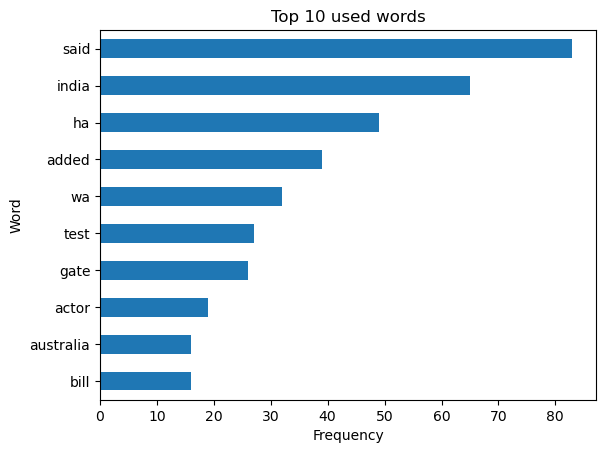

In [58]:
#visualize top 10
news_freq.head(10).plot.barh().invert_yaxis()

plt.title('Top 10 used words')
plt.xlabel('Frequency')
plt.ylabel('Word')

In [59]:
#put list of two word combos together
list(nltk.bigrams(news_df))

[('10', 'adani'),
 ('adani', 'group'),
 ('group', 'stock'),
 ('stock', 'closed'),
 ('closed', 'higher'),
 ('higher', 'wednesday'),
 ('wednesday', 'first'),
 ('first', 'occurrence'),
 ('occurrence', 'since'),
 ('since', 'report'),
 ('report', 'u'),
 ('u', 'shortseller'),
 ('shortseller', 'hindenburg'),
 ('hindenburg', 'research'),
 ('research', 'late'),
 ('late', 'january'),
 ('january', 'accused'),
 ('accused', 'group'),
 ('group', 'fraud'),
 ('fraud', 'adani'),
 ('adani', 'enterprise'),
 ('enterprise', 'led'),
 ('led', 'rally'),
 ('rally', 'advancing'),
 ('advancing', 'almost'),
 ('almost', '15'),
 ('15', 'group'),
 ('group', 'conducted'),
 ('conducted', 'investor'),
 ('investor', 'meeting'),
 ('meeting', 'singapore'),
 ('singapore', 'hong'),
 ('hong', 'kong'),
 ('kong', 'adani'),
 ('adani', 'transmission'),
 ('transmission', 'adani'),
 ('adani', 'power'),
 ('power', 'rose'),
 ('rose', '5'),
 ('5', 'daily'),
 ('daily', 'limit'),
 ('limit', 'microsoft'),
 ('microsoft', 'cofounder'),
 (

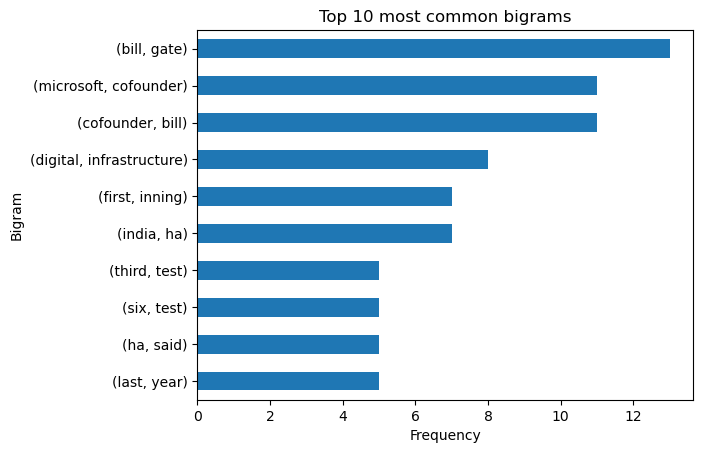

In [60]:
#visualize top ten
pd.Series(nltk.bigrams(news_df)).value_counts().head(10).plot.barh().invert_yaxis()
plt.title('Top 10 most common bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
None